In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import r2_score
import os
from scipy.stats import pearsonr


path_to_data='./data'
path_to_results='/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper'
os.chdir('/Research_Data_new/ReasearchProject/')

from genomic_prediction_programs.Experiments.data_getter import *
from genomic_prediction_programs.HelperFunctionsAndClasses.GetAraData import *
from genomic_prediction_programs.HelperFunctionsAndClasses.MeasurePerformance import *
araData = GetAraData(path_to_data='./data', maf=0.05, window_kb=200, r2=0.6)


/home/ubuntu/miniconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1> Filters the data as specified in section 2.1 <h1>

In [2]:
traits =  araData.get_trait_names()

# these traits are redundant (can be deleted out in final version)
traits.remove('Metabolite146')
traits.remove('flowering_time_10deg')
traits.remove('flowering_time_10deg_noblup')
traits.remove('leaf_number')
traits.remove('cad_concentraition_16')

# temp
#traits.remove('study_38_CL')
#traits.remove('study_16_Cd111')


# these traits are catagorical (this study only concerend with quantiative traits)
traits.remove('study_46_Gravitropic_setpoint_angle_GSA')
traits.remove('study_31_ScalingExponent')
traits.remove('study_37_Inter-specific_pollination_of_Arabidopsis_thaliana_and_Malcolmia_littorea')

def specfic_criteria(trait):
    """
    Used to further filter traits out of arapheno database
    """

    # study 2 contains multiple of the same trait measure on different occasaions
    # just want the blup main effect. 'size' traits are included in on arapheno
    # but not described
    if 'study_2_' in trait:
        return 'maineffect' in trait.lower() and 'size' not in trait.lower()

    # clim traits have no infomation as to what they are
    # rFitness is a product of two other traits already in the studyABC
    if 'study_34_' in trait:
        return 'rFitness' not in trait and 'clim' not in trait
    
    return True

# gets all the phenotypes / accession using the trait names
all_pheno = {t:araData.get_normalised_phenotype(t) for t in traits}
all_accession = {t:araData.get_k2029_accessions_with_phenotype(t) for t in traits}
# hash table for the number of observations in each trait
len_hash = {t:len(all_pheno[t]) for t in traits}

# stores filtered traits
traits_filtered = []

# sort traits by the number of accession we have for them
traits = sorted(traits, key = lambda t:len_hash[t], reverse=True)

def compare_two_traits(trait1, trait2, cor=0.70):
    """
    checks corrleation of two traits using common accusession

    returns True is they are correlated < `cor`
    """
    
    trait1_phenos = all_pheno[trait1][
        np.in1d(all_accession[trait1], all_accession[trait2])]
    
    trait2_phenos = all_pheno[trait2][
        np.in1d(all_accession[trait2], all_accession[trait1])]

    if len(trait1_phenos) < 50:
        return True

    return max(r2_score(trait1_phenos, trait2_phenos), r2_score(trait2_phenos, trait1_phenos)) < cor


for trait_q in tqdm(traits):
    add_trait = True
    if not specfic_criteria(trait_q): continue
    for trait_added in traits_filtered:
        add_trait = compare_two_traits(trait_q,trait_added)
        add_trait = add_trait and len_hash[trait_q] > 100
        if not add_trait: break
    if add_trait:
        traits_filtered.append(trait_q)


print(f'{len(traits_filtered)} traits remain after the first stage of filtering')

100%|██████████| 545/545 [00:20<00:00, 26.84it/s] 

257 traits remain after the first stage of filtering


<h3> Secound stage of filtering, includes traits with an r2 > 0.2 in any linear model or random forest <h3>

In [3]:
result_path = f'{path_to_results}/results'


info = {'trait': [], 'model': [], 'r2': []}
used = []
# colect results
for trait in traits_filtered:
        result_path = f'{path_to_results}/results'

        try:
            df_lin = pd.read_csv(f'{result_path}/{trait}_results.csv')[:3][['Model_Name', 'r2_summary']]   
            df_rf = pd.read_csv(f'{result_path}/{trait}_rf_vanilla_500_.csv')[['Model_Name', 'r2_summary']]
        except:
            print(f'error reading {trait}')
            continue
        
        df = df_lin.merge(df_rf, how='outer')
        if max(df['r2_summary']) > 0.2:
            used.append(trait)
            info['trait'].append(trait)
            result_path = f'{path_to_results}/results_choosen_traits'
            """df_lin = pd.read_csv(f'{result_path}/{trait}_linear.csv')[:3][['Model_Name', 'r2_summary']]   
            df_rf = pd.read_csv(f'{result_path}/{trait}_rf_vanilla_500.csv')[['Model_Name', 'r2_summary']]
            if os.path.exists(f'{path_to_results}/mlp_0.8r2/my_lasso_mlp_{trait}_.csv'):
                df_mlp_r2 = pd.read_csv(f'{path_to_results}/mlp_0.8r2/my_lasso_mlp_{trait}_.csv')['r2s'].mean()
                df_mlp = pd.DataFrame({'Model_Name': ['mlp'], 'r2_summary': [df_mlp_r2]})
                df = df_lin.merge(df_rf, how='outer').merge(df_mlp, how='outer')
            else:
                df = df_lin.merge(df_rf, how='outer')
                print(f'no mlp for {trait}')"""
            info['model'].append(list(df['Model_Name'])[np.argmax(df['r2_summary'])])
            info['r2'].append(list(df['r2_summary'])[np.argmax(df['r2_summary'])])
info

{'trait': ['study_12_FT10',
  'study_38_CL',
  'study_38_RL',
  'herbavore_resistance_G4MSB',
  'herbavore_resistance_G3HP',
  'herbavore_resistance_G5MSP',
  'herbavore_resistance_G2H3B',
  'herbavore_resistance_G2H4P',
  'herbavore_resistance_G2P',
  'herbavore_resistance_G4P',
  'herbavore_resistance_G3B',
  'study_2_DTFmainEffect2009',
  'study_2_YieldMainEffect2009',
  'study_31_GrowthRate',
  'study_31_FruitNumber',
  'study_4_M130T666',
  'study_16_Mo98',
  'study_16_Cd111',
  'study_44_root_length_day003',
  'study_1_FT22',
  'study_30_MeanTRL_CK',
  'study_27_MeanTRL_C',
  'study_1_FT_Field',
  'study_1_LN10',
  'study_1_LN16',
  'study_1_Width_10',
  'study_1_FLC',
  'study_1_FRI',
  'study_1_8W_GH_LN',
  'study_1_8W_GH_FT',
  'study_19_GR21',
  'study_1_SDV',
  'study_1_0W',
  'study_1_Storage_56_days',
  'study_1_Storage_28_days'],
 'model': ['Ridge',
  'Ridge',
  'Ridge',
  'Random_Forest_vanilla',
  'Lasso',
  'Random_Forest_vanilla',
  'Ridge',
  'Ridge',
  'Random_Fores

<h3> Extract the trait ontologies for each trait from the arapheno database <h3>

In [4]:
path_to_all_studies = '/Research_Data_new/ReasearchProject/all_ara_pheno'
import re
from functools import reduce


def extract_study_number(input_str):
    # Regular expression to extract the study number
    match = re.search(r"study_(\d+)_", input_str)
    
    # If a match is found, return the captured group, otherwise return None
    return match.group(1) if match else None


def extract_trait(input_str):
    # Regular expression to discard the study part and keep only the trait
    match = re.search(r"study_\d+_(.+)", input_str)
    # If a match is found, return the captured group, otherwise return None
    return match.group(1) if match else None


def mine_trait_infomation(trait):
    info_retained = ['name', 'to_name','scoring','to_definition', 'study_number']
    study_number = extract_study_number(trait)
    trait_name = extract_trait(trait)
    try:
        path  = f'{path_to_all_studies}/{study_number}/study_{study_number}_phenotypes.csv'
        df = pd.read_csv(path)
        df['study_number'] = study_number
        df = df[df['name'] == trait_name][info_retained]
        if len(df) == 0: raise FileNotFoundError
        df = df[df['name'] == trait_name][info_retained]
        df['name'] = trait
        return df
    except FileNotFoundError:
        return pd.DataFrame({info:data for info, data in zip(info_retained, [[trait]] + [[np.NAN]]*(len(info_retained)-1))})

dfs = []
for trait in used:
    dfs.append(mine_trait_infomation(trait))

df_merged =  pd.concat(dfs)


print(list(df_merged['name']))
# copied
print(len(df_merged))
df_merged.sort_values('name', inplace=True)
df_merged


['study_12_FT10', 'study_38_CL', 'study_38_RL', 'herbavore_resistance_G4MSB', 'herbavore_resistance_G3HP', 'herbavore_resistance_G5MSP', 'herbavore_resistance_G2H3B', 'herbavore_resistance_G2H4P', 'herbavore_resistance_G2P', 'herbavore_resistance_G4P', 'herbavore_resistance_G3B', 'study_2_DTFmainEffect2009', 'study_2_YieldMainEffect2009', 'study_31_GrowthRate', 'study_31_FruitNumber', 'study_4_M130T666', 'study_16_Mo98', 'study_16_Cd111', 'study_44_root_length_day003', 'study_1_FT22', 'study_30_MeanTRL_CK', 'study_27_MeanTRL_C', 'study_1_FT_Field', 'study_1_LN10', 'study_1_LN16', 'study_1_Width_10', 'study_1_FLC', 'study_1_FRI', 'study_1_8W_GH_LN', 'study_1_8W_GH_FT', 'study_19_GR21', 'study_1_SDV', 'study_1_0W', 'study_1_Storage_56_days', 'study_1_Storage_28_days']
35


,name,to_name,scoring,to_definition,study_number
0,herbavore_resistance_G2H3B,NaN,NaN,NaN,NaN
0,herbavore_resistance_G2H4P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G2P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G3B,NaN,NaN,NaN,NaN
0,herbavore_resistance_G3HP,NaN,NaN,NaN,NaN
0,herbavore_resistance_G4MSB,NaN,NaN,NaN,NaN
0,herbavore_resistance_G4P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G5MSP,NaN,NaN,NaN,NaN
0,study_12_FT10,days to flowering trait,Flowering time was scored as days until first\...,"""A flowering time trait (TO:0002616)which is t...",12
18,study_16_Cd111,cadmium concentration,Cadmium concentrations in leaves,"""A mineral and ion content related trait (TO:0...",16


Manually fill missing values

In [5]:

manual_ont = {
    'study_38_CL':'shoot system growth and development trait (TO:0000928)', 
    'study_16_Cd111':'biochemical trait (TO:0000277)',
    'study_12_FT10': 'flowering time trait (TO:0002616)',
    'study_38_RL':'shoot system growth and development trait (TO:0000928)',
    'herbavore_resistance_G4MSB':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G3HP':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G5MSP':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2H3B':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2H4P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G4P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G3B':'biochemical trait (TO:0000277)',
    'study_2_DTFmainEffect2009': 'flowering time trait (TO:0002616)',
    'study_2_YieldMainEffect2009':'yield trait (TO:0000387)',
    'study_31_GrowthRate': 'shoot system growth and development trait (TO:0000928)',
    'study_31_FruitNumber': 'yield trait (TO:0000387)',
    'study_4_M130T666':'biochemical trait (TO:0000277)',
    'study_16_Mo98':'biochemical trait (TO:0000277)',
    'study_44_root_length_day003': 'shoot system growth and development trait (TO:0000928)',
    'study_1_FT22':'flowering time trait (TO:0002616)',
    'study_30_MeanTRL_CK': 'shoot system growth and development trait (TO:0000928)',
    'study_27_MeanTRL_C': 'shoot system growth and development trait (TO:0000928)',
    'study_1_FT_Field': 'flowering time trait (TO:0002616)',
    'study_1_LN10':'shoot system growth and development trait (TO:0000928)',
    'study_1_LN16':	'shoot system growth and development trait (TO:0000928)',
    'study_1_Width_10': 'shoot system growth and development trait (TO:0000928)',
    'study_1_FLC': 'biochemical trait (TO:0000277)',
    'study_1_FRI': 'biochemical trait (TO:0000277)',
    'study_1_8W_GH_LN': 'shoot system growth and development trait (TO:0000928)',
    'study_1_8W_GH_FT':'flowering time trait (TO:0002616)',
	'study_19_GR21': 'seed dormancy trait (TO:0000253)',
    'study_1_SDV': 'flowering time trait (TO:0002616)',
    'study_1_0W': 'flowering time trait (TO:0002616)',
    'study_1_Storage_56_days':'seed dormancy trait (TO:0000253)',
    'study_1_Storage_28_days':'seed dormancy trait (TO:0000253)'  
}

manual_def = {
    'mineral and ion content trait (TO:0000465)': 'May be measured in a dry mass or in a fresh tissue. A biochemical trait (TO:0000277) that is the amount of a particular mineral or ion constituent occurring in a plant anatomical entity (PO:0025131).',
    'shoot system growth and development trait': 'A plant structure growth and development trait (TO:0000928) that is a quality of the growth of the shoot system (PO:0009006), and shoot system development stages (PO:0025527).'
}

best_model = pd.DataFrame(info).sort_values('trait')
df_merged['manual_ont'] = np.array(list(manual_ont.values()))[np.argsort(list(manual_ont.keys()))]
df_merged['best_model'] = ['Random Forest' if x == 'Random_Forest_vanilla' else x for x in best_model['model']]

# remove one trait that has r1_tree
df_merged = df_merged[df_merged['best_model'] != 'r1_tree']
df_merged['ont_high']=['biochemical trait' if e == 'biochemical trait (TO:0000277)' else 'macroscopic trait' for e in df_merged['manual_ont']]
df_merged

,name,to_name,scoring,to_definition,study_number,manual_ont,best_model,ont_high
0,herbavore_resistance_G2H3B,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G2H4P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G2P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random Forest,biochemical trait
0,herbavore_resistance_G3B,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G3HP,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Lasso,biochemical trait
0,herbavore_resistance_G4MSB,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random Forest,biochemical trait
0,herbavore_resistance_G4P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Lasso,biochemical trait
0,herbavore_resistance_G5MSP,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random Forest,biochemical trait
0,study_12_FT10,days to flowering trait,Flowering time was scored as days until first\...,"""A flowering time trait (TO:0002616)which is t...",12,flowering time trait (TO:0002616),Ridge,macroscopic trait
18,study_16_Cd111,cadmium concentration,Cadmium concentrations in leaves,"""A mineral and ion content related trait (TO:0...",16,biochemical trait (TO:0000277),Random Forest,biochemical trait


These traits were then saved in the HelperFunctionsAndClasses/FileNameManger, such that they can be retieved with GetAraData.get_selected_traits()

In [6]:
min_snps = math.inf
max_snps = 0
for trait in df_merged['name']:
    X = araData.get_genotype(trait)
    min_snps = min(min_snps, X.shape[1])
    max_snps = max(max_snps, X.shape[1])
print(min_snps, max_snps)

218128 366534


In [7]:
import pickle
pd.DataFrame(info).to_csv(f'{path_to_data}/trait_ontology_results/best_models.csv')
pickle.dump({k:v for k,v in zip(df_merged['name'], df_merged['manual_ont'])}, open(f'{path_to_data}/trait_ontology_results/filtered_trait_ont.pkl', 'wb'))
np.save(f'{path_to_data}/trait_ontology_results/filtered_traits.npy', np.array(df_merged['name']))


In [8]:
np.array(df_merged['name'])

array(['herbavore_resistance_G2H3B', 'herbavore_resistance_G2H4P',
       'herbavore_resistance_G2P', 'herbavore_resistance_G3B',
       'herbavore_resistance_G3HP', 'herbavore_resistance_G4MSB',
       'herbavore_resistance_G4P', 'herbavore_resistance_G5MSP',
       'study_12_FT10', 'study_16_Cd111', 'study_16_Mo98',
       'study_19_GR21', 'study_1_0W', 'study_1_8W_GH_FT',
       'study_1_8W_GH_LN', 'study_1_FLC', 'study_1_FRI', 'study_1_FT22',
       'study_1_FT_Field', 'study_1_LN10', 'study_1_LN16', 'study_1_SDV',
       'study_1_Storage_28_days', 'study_1_Storage_56_days',
       'study_1_Width_10', 'study_27_MeanTRL_C',
       'study_2_DTFmainEffect2009', 'study_2_YieldMainEffect2009',
       'study_30_MeanTRL_CK', 'study_31_FruitNumber',
       'study_31_GrowthRate', 'study_38_CL', 'study_38_RL',
       'study_44_root_length_day003', 'study_4_M130T666'], dtype=object)

<h3> Paper Figure 1a <h3>

Index(['biochemical trait (TO:0000277)', 'flowering time trait (TO:0002616)',
       'seed dormancy trait (TO:0000253)',
       'shoot system growth and development trait (TO:0000928)',
       'yield trait (TO:0000387)'],
      dtype='object', name='manual_ont')


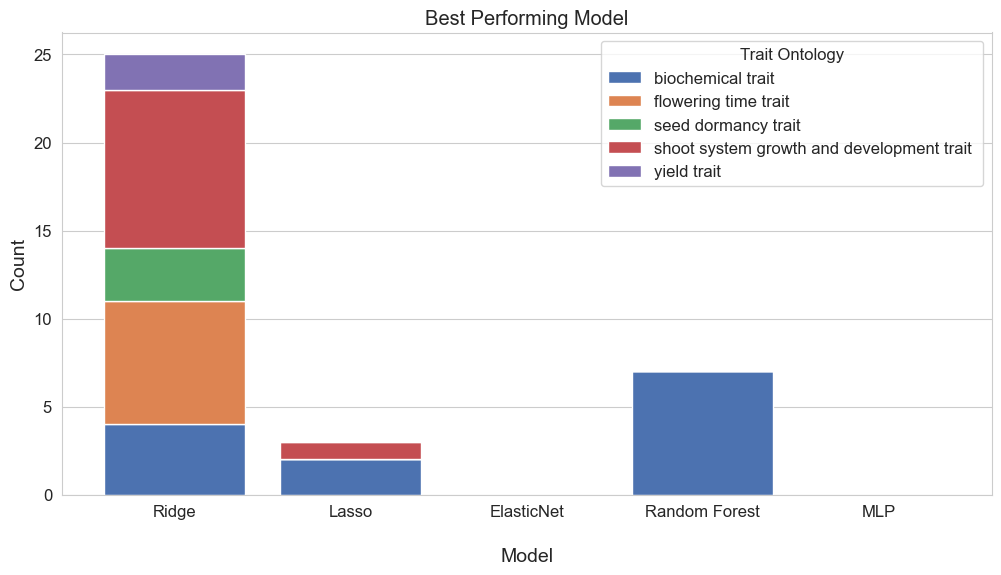

manual_ont,biochemical trait (TO:0000277),flowering time trait (TO:0002616),seed dormancy trait (TO:0000253),shoot system growth and development trait (TO:0000928),yield trait (TO:0000387)
best_model,,,,,
Ridge,4.0,7.0,3.0,9.0,2.0
Lasso,2.0,0.0,0.0,1.0,0.0
ElasticNet,0.0,0.0,0.0,0.0,0.0
Random Forest,7.0,0.0,0.0,0.0,0.0
MLP,0.0,0.0,0.0,0.0,0.0


In [6]:
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
# Desired order for categories
desired_order = ['Ridge', 'Lasso', 'ElasticNet', 'Random Forest',  'MLP']

# Count occurrences
df_count = df_merged.groupby(['best_model', 'manual_ont']).size().unstack(fill_value=0)

# Reorder df_count according to desired_order
df_count = df_count.reindex(desired_order)

# Apply Seaborn styles and set a palette
sns.set_style("whitegrid")
sns.set_palette("deep")
df_count.loc['MLP'] = 0
df_count.loc['ElasticNet'] = 0

print(df_count.columns)
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(df_count))

for type_col in df_count.columns:
    ax.bar(df_count.index, df_count[type_col], bottom=bottom, label=type_col[:type_col.index('(')])
    bottom += df_count[type_col].values

palette = sns.color_palette("deep") # You can change "deep" to any palette of your choice


ax.set_xlabel('Model', labelpad=20, fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Best Performing Model')
ax.legend(title='Trait Ontology')

ax.xaxis.grid(False)
ax.yaxis.grid(True)
path = '/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper'
plt.savefig(f'{path}/trait_model_bar.svg')
plt.show()
df_count

<h3> Paper Figure 1b <h3>

Useful helper

In [7]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
def make_violin_plot(df, title=None, save_path=None, format='svg', palette=None, ax=None, tilt=0, size=4, min_max=None, fig_size= None, x_label = None, draw_connections=True):
    plt.clf()
    sns.reset_defaults()
    if fig_size:
        sns.set(rc={'figure.figsize': fig_size})
    if palette:
        sns.set_palette(palette)
    else:
        sns.set_palette(None)

    sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 12})
    sns.swarmplot(data=df, size=size, ax=ax, palette=palette)
    # remove points that are outside 1.5 * IQR
    #sns.boxplot(data=df,color="#E6E6E6", ax=ax)
    means = df.mean(axis=0)
    plt.scatter(x=range(len(means)),y=means,c="k", zorder=10, marker='_', s=2000)

    #d = df.values
    #q1 = np.quantile(d, 0.25, axis=0)
    #q3 = np.quantile(d, 0.75, axis=0)
    #iqr = q3 - q1
    #d = d[~((d < (q1 - 1.5 * iqr)) |(d > (q3 + 1.5 * iqr))).any(axis=1)]    
    #df = pd.DataFrame(d, columns=df.columns)

    sns.violinplot(data=df, inner=None, color="#E6E6E6", ax=ax)
    #sns.violinplot(data=df, inner='stick', palette = 'Set2', ax=ax)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=tilt)
    plt.ylabel(r"$\text{r}^2$", fontsize=14)
    plt.xlabel(x_label)
    if min_max:
        plt.ylim(*min_max)


    if draw_connections:
        for idx0, idx1 in zip([i * 2 for i in range(len(df.columns)//2)],[i * 2 + 1 for i in range(len(df.columns)//2)]):
            print(idx0, idx1)
            print(plt.gca().get_children())
            locs1 = plt.gca().get_children()[idx0].get_offsets()
            locs2 = plt.gca().get_children()[idx1].get_offsets()

            # before plotting, we need to sort so that the data points
            # correspond to each other as they did in "set1" and "set2"
            sort_idxs1 = np.argsort(list(df[df.columns[idx0]]))
            sort_idxs2 = np.argsort(list(df[df.columns[idx1]]))

            # revert "ascending sort" through sort_idxs2.argsort(),
            # and then sort into order corresponding with set1
            locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]

            for i in range(locs1.shape[0]):
                x = [locs1[i, 0], locs2_sorted[i, 0]]
                y = [locs1[i, 1], locs2_sorted[i, 1]]
                if y[0] > y[1]:
                    plt.plot(x, y, color="red", alpha=0.1)
                else:
                    plt.plot(x, y, color="blue", alpha=0.1)

    if title:
        plt.title(title, fontsize=16)
    if save_path:
        pass
        #plt.savefig(save_path, format=format, dpi=300)
    if ax is None:
        return plt

[10, 10, 10, 10, 10, 10, 10, 10]


/tmp/ipykernel_318545/2885173146.py:18: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.swarmplot(data=df, size=size, ax=ax, palette=palette)


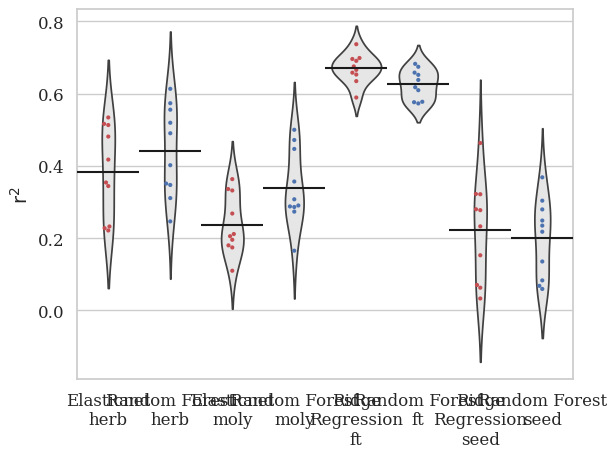

TtestResult(statistic=-4.787770488487445, pvalue=0.0009904711768866526, df=9)
TtestResult(statistic=-8.456836715342595, pvalue=1.4165507570425584e-05, df=9)
TtestResult(statistic=5.012442645585276, pvalue=0.0007265323389222366, df=9)
TtestResult(statistic=1.3447067359696785, pvalue=0.21162548810625573, df=9)


In [8]:
best_lin_herb = pd.read_csv(f'{path_to_results}/results/herbavore_resistance_G2P_results_v.csv')
best_lin_herb = np.best_lin_herb = np.array(best_lin_herb[(best_lin_herb['Model_Name'] == 'ElasticNet') & (best_lin_herb['feature_represenation'] == 'SNPs')]['r2s'])
rf_herb = pd.read_csv(f'{path_to_results}/results/herbavore_resistance_G2P_rf_vanilla_500_verbose_.csv')
rf_herb = np.array(np.array(rf_herb[rf_herb['Model_Name'] == 'Random_Forest_vanilla']['r2s']))

best_lin_moly = pd.read_csv(f'{path_to_results}/results/study_16_Mo98_results_v.csv')
best_lin_moly = np.array(best_lin_moly[best_lin_moly['Model_Name'] == 'ElasticNet']['r2s'])
rf_moly = pd.read_csv(f'{path_to_results}/results/study_16_Mo98_rf_vanilla_500_verbose_.csv')
rf_moly = rf_moly[rf_moly['Model_Name'] == 'Random_Forest_vanilla']['r2s']

best_lin_ft = pd.read_csv(f'{path_to_results}/results/study_12_FT10_results_v.csv')
best_lin_ft = np.array(best_lin_ft[(best_lin_ft['Model_Name'] == 'Ridge') & (best_lin_ft['feature_represenation'] == 'SNPs')]['r2s'])
rf_ft = pd.read_csv(f'{path_to_results}/results/study_12_FT10_rf_vanilla_500_verbose_.csv')
rf_ft = rf_ft[rf_ft['Model_Name'] == 'Random_Forest_vanilla']['r2s']

best_lin_seed_weight = pd.read_csv(f'{path_to_results}/results/study_2_YieldMainEffect2009_results_v.csv')
best_lin_seed_weight = np.array(best_lin_seed_weight[(best_lin_seed_weight['Model_Name'] == 'Ridge') & (best_lin_seed_weight['feature_represenation'] == 'SNPs')]['r2s'])
rf_seed_weight = pd.read_csv(f'{path_to_results}/results/study_2_YieldMainEffect2009_rf_vanilla_500_verbose_.csv')
rf_seed_weight = rf_seed_weight[rf_seed_weight['Model_Name'] == 'Random_Forest_vanilla']['r2s']

e= ({'Elasticnet\nherb': np.array(best_lin_herb), 'Random Forest\nherb': np.array (rf_herb),
                    'Elasticnet\nmoly':np.array(best_lin_moly),  'Random Forest\nmoly': np.array (rf_moly),
                   'Ridge\nRegression\nft': np.array(best_lin_ft), 'Random Forest\nft':  np.array (rf_ft),
                   'Ridge\nRegression\nseed': np.array(best_lin_seed_weight), 'Random Forest\nseed': np.array(rf_seed_weight)})
print([len(x) for x in e.values()])
df = pd.DataFrame({'Elasticnet\nherb': np.array(best_lin_herb), 'Random Forest\nherb': np.array (rf_herb),
                    'Elasticnet\nmoly':np.array(best_lin_moly),  'Random Forest\nmoly': np.array (rf_moly),
                   'Ridge\nRegression\nft': np.array(best_lin_ft), 'Random Forest\nft':  np.array (rf_ft),
                   'Ridge\nRegression\nseed': np.array(best_lin_seed_weight), 'Random Forest\nseed': np.array(rf_seed_weight)})

make_violin_plot(df = df[:10], size=3, fig_size=(16,5), palette=[sns.color_palette()[int(i%2==0)*3] for i in range(6)], draw_connections=False)#.savefig('genomic_prediction_programs/Experiments/TorchPractice/lassorfsummery.svg')

plt.savefig('/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/violin.svg')

plt.show()

# paired t test
import scipy
print(scipy.stats.ttest_rel(np.array(best_lin_herb), np.array(rf_herb)))
print(scipy.stats.ttest_rel(np.array(best_lin_moly), np.array (rf_moly)))
print(scipy.stats.ttest_rel(np.array(best_lin_ft), np.array (rf_ft)))
print(scipy.stats.ttest_rel(np.array(best_lin_seed_weight), np.array (rf_seed_weight)))

In [9]:
pc_best = pd.read_csv(f'{path_to_results}/pc0.3/best_pc_model_0.3.csv').sort_values('trait')
macro, biochem = [], []

info = pd.DataFrame(info).sort_values('trait')

for markers, pc, ont in zip(pd.DataFrame(info).sort_values('trait')['r2'],pc_best.sort_values('trait')['r2_best'], df_merged['manual_ont']):

    ratio = pc/markers
    if ont == 'biochemical trait (TO:0000277)':
        biochem.append(ratio)
    else:
        macro.append(ratio)


data1 = pd.DataFrame({'ratio': [a/b for a,b in zip(pc_best['r2_best'], info['r2'])], 
                     'ont': ['biochemical trait' if e == 'biochemical trait (TO:0000277)' else 'macroscopic trait' for e in df_merged['manual_ont']]})


print(data1.groupby('ont').mean())



                      ratio
ont                        
biochemical trait  0.677957
macroscopic trait  0.903946


{'herbavore_resistance_G2H3B': 'biochemical trait (TO:0000277)', 'herbavore_resistance_G2H4P': 'biochemical trait (TO:0000277)', 'herbavore_resistance_G2P': 'biochemical trait (TO:0000277)', 'herbavore_resistance_G3B': 'biochemical trait (TO:0000277)', 'herbavore_resistance_G3HP': 'biochemical trait (TO:0000277)', 'herbavore_resistance_G4MSB': 'biochemical trait (TO:0000277)', 'herbavore_resistance_G4P': 'biochemical trait (TO:0000277)', 'herbavore_resistance_G5MSP': 'biochemical trait (TO:0000277)', 'study_12_FT10': 'flowering time trait (TO:0002616)', 'study_16_Cd111': 'biochemical trait (TO:0000277)', 'study_16_Mo98': 'biochemical trait (TO:0000277)', 'study_19_GR21': 'seed dormancy trait (TO:0000253)', 'study_1_0W': 'flowering time trait (TO:0002616)', 'study_1_8W_GH_FT': 'flowering time trait (TO:0002616)', 'study_1_8W_GH_LN': 'shoot system growth and development trait (TO:0000928)', 'study_1_FLC': 'biochemical trait (TO:0000277)', 'study_1_FRI': 'biochemical trait (TO:0000277)', 

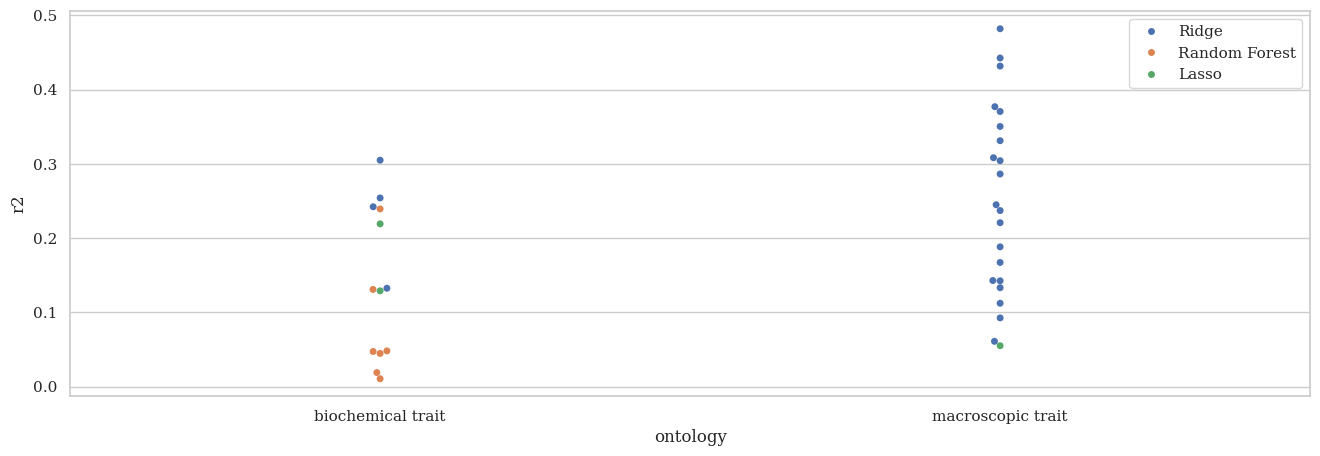

TtestResult(statistic=2.6136077956686457, pvalue=0.013391546262184093, df=33.0)
0.24922172440754126
0.14020574040245204


In [10]:
traits = araData.get_filtered_traits()
lat_long_10001 = pd.read_csv('/Research_Data_new/ReasearchProject/data/10001_genomes_lat_long.csv')

result = {'trait': [], 'r2': []}
for trait in traits:
    phenotypes = araData.get_normalised_phenotype(trait)
    accessions = araData.get_k2029_accessions_with_phenotype(trait).astype(int)
    lat_long = lat_long_10001[np.isin(np.array(lat_long_10001['Accession ID']), accessions)][['Lat', 'Long']]
   
    lat = np.array(lat_long['Lat'])
    long = np.array(lat_long['Long'])

    lat_min, lat_max = -40, 60
    long_min, long_max = 20,70
    nans = np.argwhere(np.isnan(lat))
    lat = (np.delete(lat,nans,0))
    long = (np.delete(long,nans,0))

    x,y = np.vstack((long**2, lat**2)).T, phenotypes
    x,y = np.vstack((long, lat, np.array([lat[i] * long[i] for i in range(len(lat))]))).T, phenotypes
    x,y = np.vstack((long, lat, np.array([lat[i] * long[i] for i in range(len(lat))]), long**2, lat**2)).T, phenotypes


    y = np.delete(y,nans,0)

    in_lat = (x[:,0] > lat_min) & (x[:,0] < lat_max)
    in_long = (x[:,1] > long_min) & (x[:,1] < long_max)
    in_domain = in_lat & in_long
    x,y = x[in_domain], y[in_domain]
    if len(x) < 10:
        print(trait)
        continue
    
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    result['trait'].append(trait)
    result['r2'].append(r2_score(y,y_pred))
    
ont = araData.get_filtered_traits_ontology_dict() 
print(ont)
ont = {t: 'biochemical trait' if v == 'biochemical trait (TO:0000277)' else 'macroscopic trait' for t, v in ont.items()}
low_ont = araData.get_filtered_traits_ontology_dict() 
data2 = pd.DataFrame({'trait': result['trait'], 'ontology': [ont[t] for t in result['trait']], 'r2': result['r2'], 'low_ont': [low_ont[t][:low_ont[t].index('(')] for t in result['trait']]})

import seaborn as sns

sns.swarmplot(data2, x = 'ontology', y = 'r2', hue=list(df_merged['best_model']), palette='deep')                                          
plt.savefig('ont_model.svg')
plt.show()
print(scipy.stats.ttest_ind(data2[data2['ontology'] == 'macroscopic trait']['r2'], data2[data2['ontology'] == 'biochemical trait']['r2']))

print(data2[data2['ontology'] == 'macroscopic trait']['r2'].mean())
print(data2[data2['ontology'] == 'biochemical trait']['r2'].mean())

In [13]:

import os
import pandas as pd
import scipy

path_to_gwas = '/Research_Data_new/ReasearchProject/gwas'
print(os.listdir())

def mine_GWAS(trait):
    return pd.read_csv(f'{path_to_gwas}/{trait}/Output/Linear_Mixed_Model/{trait}/{trait}_mod_sub_{trait}_k2029.assoc.txt', sep='\t')

def get_skewness(trait, skew=False):
    return scipy.stats.kurtosis(np.log((mine_GWAS(trait)['p_wald'])))

os.chdir('/Research_Data_new/ReasearchProject')

import seaborn as sns
data3 = pd.DataFrame({'trait ontology': df_merged['ont_high'], 'skew': map(lambda x:get_skewness(x,skew=False), list(df_merged['name'])), 'best_model': list(df_merged['best_model']), 'name': list(df_merged['name'])})
#data3['best_model'].replace('Random_Forest_vanilla', 'Random Forest', inplace=True)
data3['skew'] = np.log(data3['skew'])


['herbavore_resistance_G4MSB_accessions', 'study_4_M130T666_accessions', 'genomic_prediction_programs', 'arapheno_parsed', 'flowering_time_10deg_accessions', 'filter.py', 'cad_concentraition_16_accessions', 'meanstomatasize_accessions', 'herb_pca.svg', 'herbavore_resistance_G3HP_accessions', 'david_kinship', 'primary_branch_number_accessions', 'mini.py', 'seed_weight_137_accessions', 'LICENSE', 'Ca43_accessions', 'rf_lasso_indidual_results.csv', 'study_12_FT10_accessions', 'stem_length_accessions', 'gwas', 'leaf_number_accessions', 'flower_diameter_accessions', 'pcs_explaining_summary.svg', 'Ra85_accessions', 'flowering_gwas.png', 'kurtosis.svg', 'all_ara_pheno', '_vcf2gwas_temp_20240224_050948', 'flowering_time_10deg.svg', 'met_pca.svg', 'study_1_0W_accessions', 'Output', 'pc_gen.py', 'scratch-paper.ipynb', 'herbavore_resistance_G5MSP_accessions', 'period', 'lat_long_ft.svg', 'misc', 'README.pdf', 'period_accessions', 'test_linear_models.ipynb', 'pca_2d.svg', 'flowering_time_10deg_nob

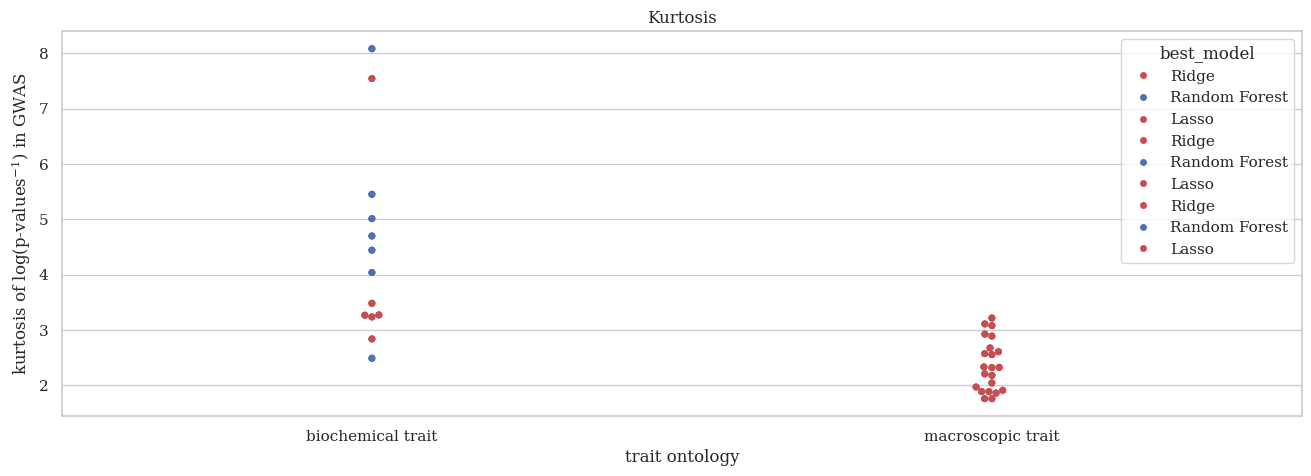

In [16]:

sns.swarmplot(data = data3, x= 'trait ontology', y = 'skew', hue = 'best_model')
plt.ylabel('kurtosis of log(p-values$\mathregular{^{-1}}$) in GWAS')
plt.title('Kurtosis')

#print(scipy.stats.ttest_ind(df[df['trait ontology'] == 'biochemical trait']['skew'], df[df['trait ontology'] == 'macroscopic trait']['skew']))

plt.savefig('kurtosis.svg')
plt.show()

TtestResult(statistic=5.373883517292044, pvalue=6.119387915278096e-06, df=33.0)
TtestResult(statistic=2.600113183617334, pvalue=0.013834485137179242, df=33.0)
TtestResult(statistic=2.6136077956686457, pvalue=0.013391546262184093, df=33.0)


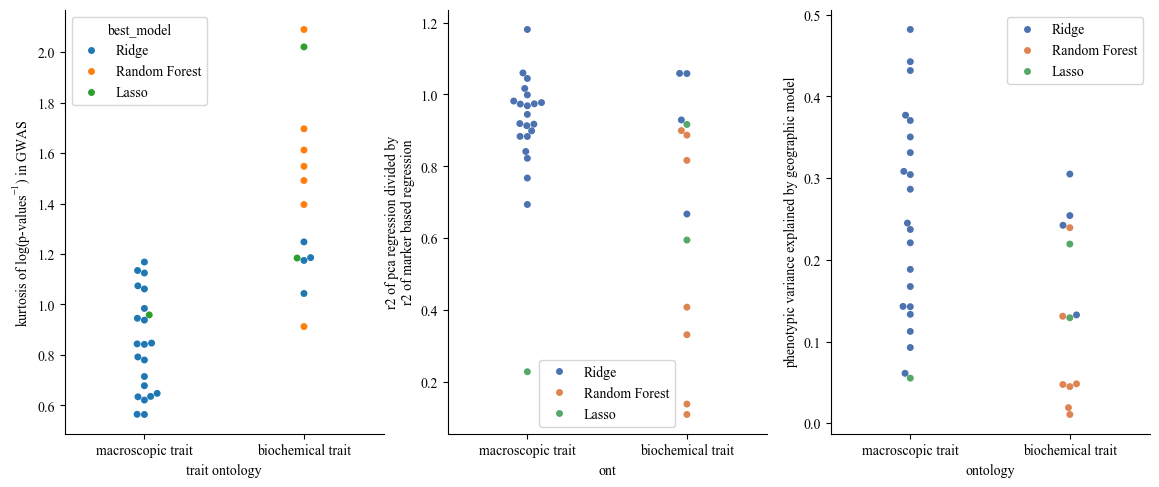

In [126]:
fig, axs = plt.subplots(1,3,figsize=(14,5.5))
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'

# increase font si

sns.swarmplot(data1, x='ont', y='ratio', hue=list(df_merged['best_model']), ax=axs[1], palette='deep', order=['macroscopic trait', 'biochemical trait'])
axs[1].set_ylabel('r2 of pca regression divided by\nr2 of marker based regression')

sns.swarmplot(data2, x = 'ontology', y = 'r2', hue=list(df_merged['best_model']), palette='deep', ax=axs[2], order=['macroscopic trait', 'biochemical trait'])                                     
axs[2].set_ylabel('phenotypic variance explained by geographic model')



sns.swarmplot(data = data3, x= 'trait ontology', y = 'skew', hue = 'best_model', ax=axs[0], order=['macroscopic trait', 'biochemical trait'])
axs[0].set_ylabel('kurtosis of log(p-values$\mathregular{^{-1}}$) in GWAS')

for i in range(3):
    ax.tick_params(axis='y', labelsize=7)
    for pos in ['right', 'top' ]: 
        axs[i].spines[pos].set_visible(False) 

print(scipy.stats.ttest_ind(df[df['trait ontology'] == 'biochemical']['skew'], df[df['trait ontology'] == 'macroscopic']['skew']))
print(scipy.stats.ttest_ind(data1[data1['ont'] == 'macroscopic trait']['ratio'], data1[data1['ont'] == 'biochemical trait']['ratio']))
print(scipy.stats.ttest_ind(data2[data2['ontology'] == 'macroscopic trait']['r2'], data2[data2['ontology'] == 'biochemical trait']['r2']))


plt.savefig(f'{path_to_results}/all.svg')

In [ ]:
/Research_Data_new/ReasearchProject/gwas/study_12_FT10/study_12_FT10/Output/Linear_Mixed_Model/study_12_FT10/flowering_time_10deg_mod_sub_flowering_time_10deg_k2029.log.txt
/Research_Data_new/ReasearchProject/gwas/study_12_FT10/Output/Linear_Mixed_Model/study_12_FT10/study_12_FT10_mod_sub_study_12_FT10_k2029.assoc.txt

In [ ]:
/Research_Data_new/ReasearchProject/gwas/study_12_FT10/study_12_FT10/Output/Linear_Mixed_Model/study_12_FT10/flowering_time_10deg_mod_sub_flowering_time_10deg_k2029.log.txt

In [ ]:
best_models = list(df_merged['best_model'])
best_model_counts = [best_models.count(m) for m in set(best_models)] + [0,0] # 0,0 for MLP and ElasticNet
best_model_counts
import scipy
scipy.stats.chi2_contingency(best_model_counts)

ValueError: The internally computed table of expected frequencies has a zero element at (3,).

In [ ]:
from matplotlib.scale import FuncScale

def forward(x):
    def f(x):
        if x >= 0:
            return x
        else:
            return x / 30 
    return np.array([f(i) for i in x])

def inverse(x):
    def f(x):
        if x >= 0:
            return x
        else:
            return x * 30
    return np.array([f(i) for i in x])

In [ ]:
feature_rep = 'PCA_SNPs'
metric = 'r2s'
import pandas as pd

def get_pca_mlp(trait, model):
    df =  pd.read_csv(f'{path_to_results}/mlp_pca0.6/_{trait}_.csv')
    return (df[metric].groupby(df['variance_maintained']).mean())

def get_pca_rf(trait, model):
    df = pd.read_csv(f'{path_to_results}/pc_rf/_{trait}_rf_verbose_..csv')
    return (df[metric].groupby(df['variance_maintained']).mean())


def get_pca_regression(trait, model):
    df = pd.read_csv(f'{path_to_results}/pca_other/_{trait}_linear_verbose_.csv')
    df = df[df['Model_Name'] == model]
    return df[metric].groupby(df['variance_maintained']).mean()

def get_baseline(trait, model):
    print(trait, model)
    if model == 'rf':
        r = np.array(pd.read_csv(f'{path_to_results}/results/{trait}_rf_vanilla_500_verbose_.csv')[metric]).mean()
    if model == 'MLP':
        r = np.array(pd.read_csv(f'{path_to_results}/mlp_0.6r2/_{trait}_.csv')[metric]).mean()
    if model in ['Ridge', 'Lasso', 'ElasticNet']:
        df = pd.read_csv(f'{path_to_results}/results/{trait}_results.csv')
        r =  np.array(df[df['Model_Name'] == model]['r2_summary'])[0]
    return r    

In [ ]:
trait = 'study_4_M130T666'

feature_representation = 'PCA_SNPs'
models = ['Ridge', 'Lasso', 'ElasticNet',  'MLP', 'rf'][::-1]

model_f = {'Ridge':get_pca_regression, 'Lasso':get_pca_regression, 'ElasticNet':get_pca_regression, 'MLP':get_pca_mlp, 'rf':get_pca_rf}

def get_datas(trait):
    datas = {}
    for model in models:
        datas[model] = model_f[model](trait, model)
    return pd.DataFrame(datas)
        

print(get_datas(trait))

                           rf       MLP  ElasticNet     Lasso     Ridge
variance_maintained                                                    
0.05                -0.072614  0.027547   -0.011071  0.003307  0.003580
0.10                 0.005539  0.140630    0.057873  0.093361  0.096437
0.20                 0.050507  0.093074    0.053221  0.077693  0.097407
0.30                 0.060074 -0.001928    0.058273  0.074785  0.079181
0.40                 0.058720  0.132623    0.067342  0.077867  0.096636
0.50                 0.052737 -0.020823    0.039675  0.062958  0.097062
0.60                 0.051997  0.129492    0.025985  0.085283  0.125246
0.70                 0.035035  0.135077    0.024085  0.078065  0.095499
0.80                 0.029934  0.166466    0.015757  0.084331  0.120147
0.90                 0.024495  0.107083    0.015918  0.079438  0.113303
0.95                 0.025985  0.104834    0.020189  0.080979  0.128180
0.97                 0.020518  0.135877    0.015385  0.081036  0

study_12_FT10 rf
study_12_FT10 MLP
study_12_FT10 ElasticNet
study_12_FT10 Lasso
study_12_FT10 Ridge
herbavore_resistance_G2P rf
herbavore_resistance_G2P MLP
herbavore_resistance_G2P ElasticNet
herbavore_resistance_G2P Lasso
herbavore_resistance_G2P Ridge
study_4_M130T666 rf
study_4_M130T666 MLP
study_4_M130T666 ElasticNet
study_4_M130T666 Lasso
study_4_M130T666 Ridge


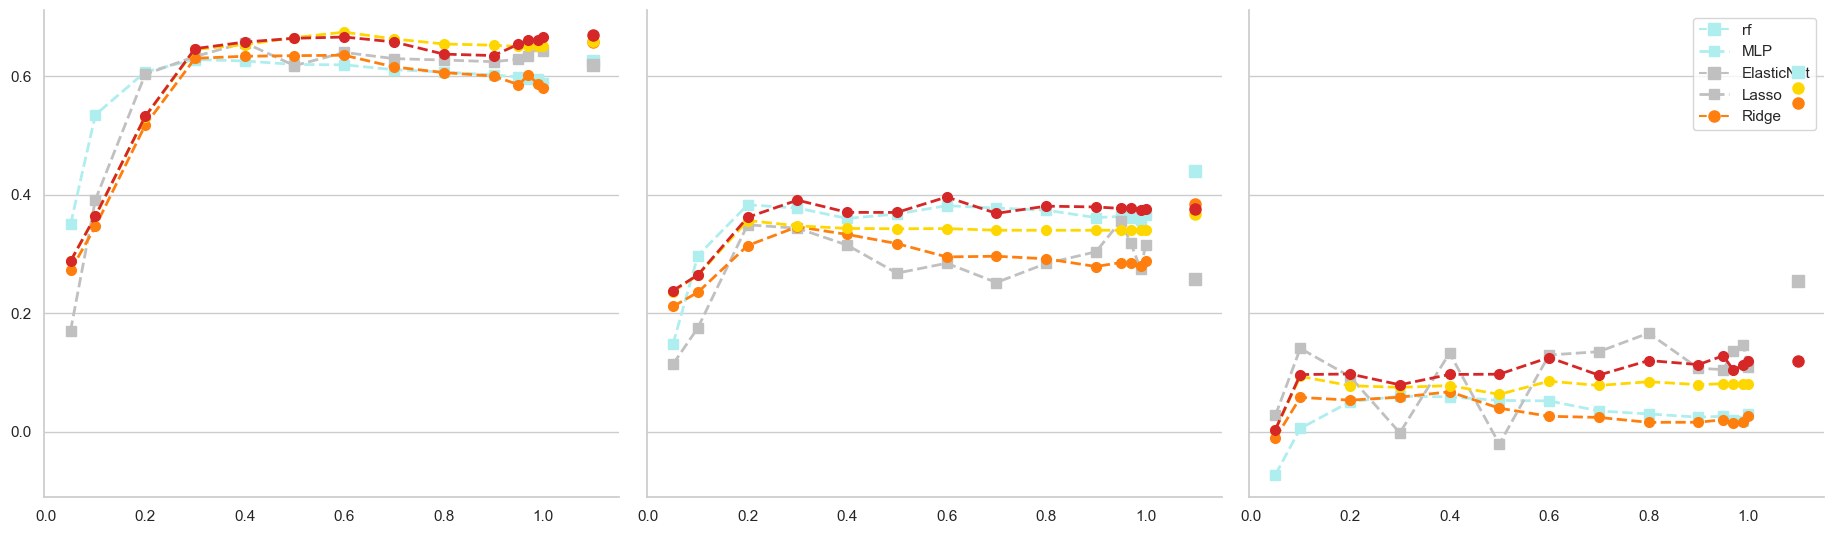

In [ ]:
colors = ['tab:red', 'gold', 'tab:orange', 'silver', 'lightskyblue'][::-1]
colors = ['tab:red', 'gold', 'tab:orange', 'silver', 'paleturquoise'][::-1]
import seaborn as sns
sns.set_theme(style='whitegrid')
connections = []

fig, axs = plt.subplots(1,3, sharey = True, figsize=(18.5, 5.5))
#ax1 = ax[0]
#ax1.set_ylabel('r2')
#ax1.set_xlabel('Total Variance Explained by Principal Components')
#ax1.set_ylim(-1,0.8)




for ax in axs:
    ax.grid(axis='x')
    #ax.set_yscale('function', functions=(forward, inverse))
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])


    for pos in ['right', 'top' ]: 
        ax.spines[pos].set_visible(False) 


models = ['Ridge', 'Lasso', 'ElasticNet',  'MLP', 'rf'][::-1]
traits = ['study_12_FT10','herbavore_resistance_G2P', 'study_4_M130T666']
for axis, trait in zip(axs, traits):
    data = get_datas(trait)
    for i, model in enumerate(models):
        if i  < 2: marker = 's'
        else: marker = 'o'
        color = colors[i]



        base = get_baseline(trait, model)



        
        axis.plot(1.1, [base], color=color,linestyle='--', marker=marker,  zorder=100, markersize=8)
        axis.plot(data.index, (data[model]), color=color, linestyle='--', marker=marker, zorder=100, markersize=7, linewidth=2)


       
# add figure legand
plt.legend(models, loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig(f"{path_to_results}/pca.svg")
plt.show()

In [ ]:
# Data
data = {'Ridge': 33, 'Lasso': 2, 'RF': 4, 'R0': 2}

# Separate the keys and values from the dictionary
categories = list(data.keys())
values = list(data.values())

# Create the bar plot
plt.bar(categories, values)

# Add labels and title if needed
plt.xlabel('Algorithm')
plt.ylabel('Value')
plt.title('Bar Plot Example')

# Show the plot
plt.show()

In [ ]:
result_path = '/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results'
counts = [0,0,0,0,0]
for trait in traits_filtered:
    if not 'herb' in  trait and not 'study_16_' in trait and not 'study_4_' in trait and not 'study_1_' in trait and 'delta_13' not in trait:
        try:
            df = pd.read_csv(f'{result_path}/{trait}_results.csv')[:3][['Model_Name', 'r2_summary']]
            df_rf = pd.read_csv(f'{result_path}/{trait}_rf_vanilla_500_.csv')[['Model_Name', 'r2_summary']]
            df_base = pd.read_csv(f'{result_path}/{trait}_r1_tree_.csv')[['Model_Name', 'r2_summary']]
        except:
            continue
        df = df.merge(df_rf, how='outer').merge(df_base,how='outer')
        if max(df['r2_summary']) > 0.2:
            counts[np.argmax(df['r2_summary'])] += 1
            used.append(trait)
            if np.argmax(df['r2_summary']) == 4:
                print(trait)
print(used)
counts

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import r2_score
import os

def side_by_side(y_trues, y_preds, names, alpha, s, trait):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5.5), sharey=True)
    for i in range(2):
        # make square axes
        # draw y=x line
        # set axes limits
        std = np.std(list(y_trues.flatten()) + list(y_preds.flatten()))
        max_x = max(max(y) for y in [y_trues.flatten(), y_preds.flatten()]) + std
        min_x = min(min(y) for y in [y_trues.flatten(), y_preds.flatten()]) - std
        ax[i].set_xlim(min_x, max_x)
        ax[i].set_ylim(min_x, max_x)
        ax[i].plot([min_x, max_x], [min_x, max_x], ls="--", c=".3")

        ax[i].scatter(y_trues[i], y_preds[i], s=s, alpha=alpha)

        

        ax[i].set_title(names[i])
        ax[i].set_box_aspect(1)


        # set figure title
        fig.suptitle(f"{trait}", fontsize=15)
    
    # set commmon y label
    fig.text(0.04, 0.5, 'Predicted Values', va='center', rotation='vertical', fontsize=15)
    # set common x label
    fig.text(0.5, 0.04, 'True Values', ha='center', fontsize=15)
    return fig

result_path = '/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results'
counts = [0,0,0,0,0]
for trait in traits_filtered:
    if not 'herb' in  trait and not 'study_16_' in trait and not 'study_4_' in trait and not 'study_1_' in trait and 'delta_13' not in trait:
        try:
            df = pd.read_csv(f'{result_path}/{trait}_results.csv')[:3][['Model_Name', 'r2_summary']]
            df_rf = pd.read_csv(f'{result_path}/{trait}_rf_vanilla_500_.csv')[['Model_Name', 'r2_summary']]
            df_base = pd.read_csv(f'{result_path}/{trait}_r1_tree_.csv')[['Model_Name', 'r2_summary']]
        except:
            continue
        df = df.merge(df_rf, how='outer').merge(df_base,how='outer')
        if max(df['r2_summary']) > 0.2:
            counts[np.argmax(df['r2_summary'])] += 1
            used.append(trait)
            if np.argmax(df['r2_summary']) == 4:
                print(trait)
print(used)
counts

In [ ]:
d = "/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results"
d = [e for e in os.listdir(d) if e.endswith(".csv") and '_v' not in e]
print(len(d))
for exp in d:
    df = pd.read_csv(f"/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results/{exp}")
    if max(df['r2_summary'])==df.at[5, 'r2_summary']:
        print(exp[:exp.index('_results.csv')], end=': ')
        #print(df['r2_summary'])

        r2s = []
        trait = exp[:exp.index('_results.csv')]
        for model in ['elasticnetSNPs', 'ridgeSNPs', 'lassoSNPs']:
            regression = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results_indivdual/{trait}{model}.csv')
            rf = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results_indivdual/{trait}rf.csv')
            y_trues_regression, y_trues_rf   = regression['y_true'], rf['y_true']
            y_preds_regression, y_preds_rf   = regression['y_pred'], rf['y_pred']
            r2_regression = r2_score(y_trues_regression, y_preds_regression)
            r2s.append((r2_regression, model))
        print(max(r2s), 'rf: ', r2_score(y_trues_rf, y_preds_rf))



In [ ]:
trait = 'study_1_Cd114'
# elasticnetSNPs, ridgeSNPs, LassoSNPs

model_r, model_rf = 'lassoSNPs', 'rf'
regression = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results_indivdual/{trait}{model_r}.csv')
rf = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results_indivdual/{trait}{model_rf}.csv')

y_trues = np.array([regression['y_true'], rf['y_true']])
y_preds = np.array([regression['y_pred'], rf['y_pred']])
names = [model_r + f'\nr2 {(round(r2_score(y_trues[0], y_preds[0]),2))}', f'Lasso Random Forest SNPs' + f'\nr2 {(round(r2_score(y_trues[1], y_preds[1]),2))}']
fig = side_by_side(y_trues, y_preds, names, alpha=0.7, s=10, trait=trait)

for i in range(len(y_preds)):
    print(names[i], r2_score(y_trues[i], y_preds[i]))

fig.savefig(f'genomic_prediction_programs/Experiments/Paper/{trait}')

In [ ]:
fig.savefig(f"/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/{trait}.svg")

In [ ]:
trait = 'study_1_FRI'
model_r, model_rf = 'elasticnetSNPs', 'rf'
enet = pd.read_csv(f'/Research_Data/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results_indivdual/{trait}{model_r}.csv')
rf = pd.read_csv(f'/Research_Data/ReasearchProject/genomic_prediction_programs/Experiments/Paper/results_indivdual/{trait}{model_rf}.csv')

y_trues = np.array([enet['y_true'], rf['y_true']])
y_preds = np.array([enet['y_pred'], rf['y_pred']])
names = [model_r, model_rf]
side_by_side(y_trues, y_preds, names, alpha=0.5, s=10, trait = trait)

print('r2 scores:')
for i in range(len(y_preds)):
    print(names[i], r2_score(y_trues[i], y_preds[i]))


In [ ]:
ind_herb

In [ ]:
r2_score(y_true1, y_pred1)

In [ ]:
trait = 'herbavore_resistance_G2P'
ind_herb = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Aim1/indivdual_results_new/{trait}_lasso_3_fold_0.05_enet_default_path_for_indSNPS_individual_pca-.csv')
ind_herb = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Aim1/indivdual_results/_herbavore_resistance_G2P_SNPS_enet.csv')

y_pred1 = []
y_true1 = []

for accesion in set(ind_herb['test_index']):
    acc_estimates = ind_herb[ind_herb['test_index'] == accesion]
    y_true1.append(list(acc_estimates['y_true'])[0])
    y_pred1.append(list(acc_estimates['y_pred'])[0])
    #y_pred1.append(sum(acc_estimates['y_pred'])/len(acc_estimates))
    #y_true1.append(sum(acc_estimates['y_true'])/len(acc_estimates))
#/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Aim1/indivdual_results/_herbavore_resistance_G2P_SNPS_enet.csv
ind_herb = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/TorchPractice/tabular_results/{trait}_random_forest_500_trees_pca_lasso_embedding_final_ind.csv_new')

y_pred2 = []
y_true2 = []

for accesion in set(ind_herb['test_index']):
    acc_estimates = ind_herb[ind_herb['test_index'] == accesion]
    y_true2.append(list(acc_estimates['y_true'])[0])
    y_pred2.append(list(acc_estimates['y_pred'])[0])
    #y_pred2.append(sum(acc_estimates['y_pred'])/len(acc_estimates))
    #y_true2.append(sum(acc_estimates['y_true'])/len(acc_estimates))

fig = side_by_side(y_trues = np.array([y_true1, y_true2]), y_preds= np.array(np.array([y_pred1, y_pred2])), names = ['enet', 'rf'], alpha=0.25, s=8, trait='Herbavore Resistance').savefig(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/figures/herb_new_pres.svg')


In [ ]:
print(r2_score(y_true1, y_pred1))   
print(r2_score(y_true2, y_pred2))


In [ ]:
#ind_herb = pd.read_csv('/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Aim1/indivdual_results_new/{trait}_ridge_3_fold_0.05_enet_default_path_for_indSNPS_individual_pca-.csv')
ind_herb = pd.read_csv('/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Aim1/indivdual_results_new/study_16_Mo98_lasso_3_fold_0.05_enet_default_path_for_indSNPS_individual_pca-.csv')


y_pred1 = []
y_true1 = []

for accesion in set(ind_herb['test_index']):
    acc_estimates = ind_herb[ind_herb['test_index'] == accesion]
    y_true1.append(list(acc_estimates['y_true'])[0])
    y_pred1.append(list(acc_estimates['y_pred'])[0])
    #y_pred1.append(sum(acc_estimates['y_pred'])/len(acc_estimates))
    #y_true1.append(sum(acc_estimates['y_true'])/len(acc_estimates))

#ind_herb = pd.read_csv('/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/TorchPractice/tabular_results/{trait}_random_forest_500_trees_pca_lasso_embedding_final_ind.csv_new')
ind_herb = pd.read_csv('/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/TorchPractice/tabular_results/study_16_Mo98_random_forest_500_trees_pca_lasso_embedding_final_ind.csv_new')

y_pred2 = []
y_true2 = []
for accesion in set(ind_herb['test_index']):
    acc_estimates = ind_herb[ind_herb['test_index'] == accesion]
    #y_true2.append(list(acc_estimates['y_true'])[0])
    #y_pred2.append(list(acc_estimates['y_pred'])[0])
    y_pred2.append(sum(acc_estimates['y_pred'])/len(acc_estimates))
    y_true2.append(sum(acc_estimates['y_true'])/len(acc_estimates))

side_by_side(y_trues = np.array([y_true1, y_true2]), 
             y_preds = np.array(np.array([y_pred1, y_pred2])), names = ['lasso', 'rf'], alpha=0.5, s=8, trait='Molybdenum Concentration').savefig(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/figures/moly.svg')


In [ ]:
print(r2_score(y_true1, y_pred1))   
print(r2_score(y_true2, y_pred2))

In [ ]:
lasso = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Aim1/indivdual_results_new/{trait}_lasso_3_fold_0.05_enet_default_path_for_indSNPS_individual_pca-.csv')
r2_scores = []
for i in range(0, len(lasso), len(lasso)//30):
    r2_scores.append(r2_score(lasso['y_true'][i:i+30], lasso['y_pred'][i:i+30]))

sum(r2_scores)/len(r2_scores)


In [ ]:
r2_score(y_true1, y_pred1)

In [ ]:
trait = 'study_1_FRI'
import pandas as pd
ind_herb = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Aim1/indivdual_results_new/{trait}_lasso_3_fold_0.05_enet_default_path_for_indSNPS_individual_pca-.csv')

y_pred1 = []
y_true1 = []

for accesion in set(ind_herb['test_index']):
    acc_estimates = ind_herb[ind_herb['test_index'] == accesion]
    #y_true1.append(list(acc_estimates['y_true'])[0])
    #y_pred1.append(list(acc_estimates['y_pred'])[0])
    y_pred1.append(sum(acc_estimates['y_pred'])/len(acc_estimates))
    y_true1.append(sum(acc_estimates['y_true'])/len(acc_estimates))

ind_herb = pd.read_csv(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/TorchPractice/tabular_results/{trait}_random_forest_500_trees_pca_lasso_embedding_final_ind.csv_new')

y_pred2 = []
y_true2 = []
for accesion in set(ind_herb['test_index']):
    acc_estimates = ind_herb[ind_herb['test_index'] == accesion]
    #y_true2.append(list(acc_estimates['y_true'])[0])
    #y_pred2.append(list(acc_estimates['y_pred'])[0])
    y_pred2.append(sum(acc_estimates['y_pred'])/len(acc_estimates))
    y_true2.append(sum(acc_estimates['y_true'])/len(acc_estimates))

side_by_side(y_trues = np.array([y_true1, y_true2]), y_preds= np.array(np.array([y_pred1, y_pred2])), names = ['lasso', 'rf'], alpha=0.5, s=8, 
             trait=trait).savefig(f'/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/figures/{trait}.svg')

In [ ]:
#for trait in araData.rf_best_traits:
with open('/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/detect_nonlin.txt', 'w') as f:
    f.write('trait,linear,non_linear\n')
    for trait in araData.rf_best_traits:
        X = araData.get_genotype(trait)
        y = araData.get_normalised_phenotype(trait)
        rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
        rf.fit(X, y)
        features = np.argsort(rf.feature_importances_)[::-1][:3]
        X_pairwise = np.array([[a*b for a,b in (itertools.product(x,x))] for x in X]) 
        linear = Result_10fold(LinearRegression(), X, y, important_parameters={}, cv=my_RepeatedKfold(k=10, repeats=1))
        non_linear = Result_10fold(LinearRegression(), X_pairwise, y, important_parameters={},cv=my_RepeatedKfold(k=10, repeats=1))
        f.write(f'{trait},{(linear.r2)},{(non_linear.r2)}\n')
        print(f'{trait},{(linear.r2)},{(non_linear.r2)}\n')

print(linear.r2, non_linear.r2)

In [ ]:
#### test performance using 2 PCs
araData = GetAraData(path_to_data='./data', maf=0.05, window_kb=200, r2=0.6)
pc_r2 = {'trait': [], 'r2': []}
for i, trait in enumerate(used):
    x = araData.get_pca_feature_reduced_SNPs(trait, variance_maintained=0.3)
    y = araData.get_phenotype(trait)

    result = test_ridge_model(x,y, cv=my_Kfold())
    rf = Result_10fold(RandomForestRegressor(n_estimators=500), x,y, important_parameters={},cv=my_Kfold())
    r2 = max([r.r2 for r in result]+ [rf.r2])
    
    pc_r2['trait'].append(trait)
    pc_r2['r2'].append(r2)
    print(i)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s[CV] END .................................................... total time=   0.1s



[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.7s remaining:    2.7s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/home/ubuntu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.615867614746094, tolerance: 20.85012435913086
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1117.0592041015625, tolerance: 20.687450408935547
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

KeyboardInterrupt: 